In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.solvers.sde import Euler
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.stochastic_processes.cell_model import CellDiffusionProcess, CellDiffusionProcessAux
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.mcmc.pcn import PreconditionedCrankNicolson

In [2]:
dim = 2
alpha = 1. / 16.
sigma = .1
T = 4.0
dt = 1./500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)

In [3]:
wiener_process = WienerProcess(dim, dtype, rng_key)
sde = CellDiffusionProcess(alpha, sigma, T=T, dt=dt)
solver = Euler(sde)

dWs = wiener_process.sample_path(sde.ts).xs
path = solver.solve(x0, dWs=dWs)

In [4]:
path.log_likelihood

Array(0., dtype=float32)

Text(0.5, 1.0, 'Unconditional process')

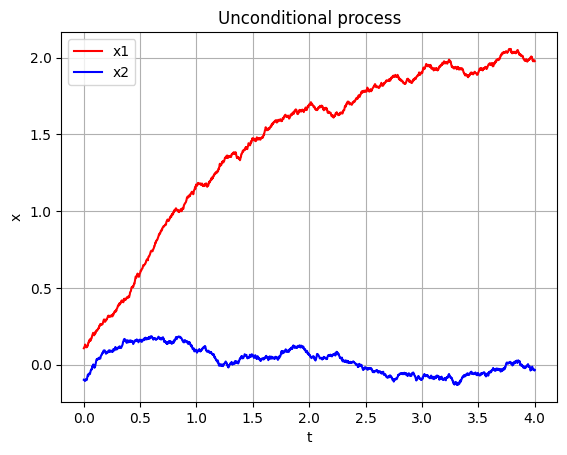

In [5]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r')
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.title("Unconditional process")

In [6]:
aux_sde = CellDiffusionProcessAux(alpha, sigma, T=4.0, dt=1./500.)
L0 = jnp.eye(dim, dtype=dtype)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
# xT = jnp.array([2.0, -0.1], dtype=dtype)
xT = jnp.array([1.0, -0.1], dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
guided_sde = GuidedBridgeProcess(sde, aux_sde, L0, Sigma0, start=x0, target=xT)
solver = Euler(guided_sde)
path = solver.solve(x0, dWs=dWs, log_likelihood=True)

Text(0.5, 1.0, 'Guided process')

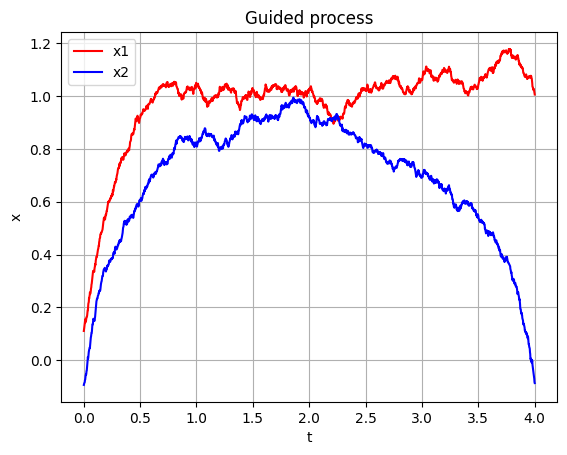

In [7]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r')
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.title("Guided process")

In [8]:
mcmc_model = PreconditionedCrankNicolson(
    rho=0.98,
    x0=x0,
    guided_process=guided_sde,
    rng_key=rng_key,
)

In [9]:
# %%prun -s cumulative -q -l 10 -T prun0

path_mcmc, lls = mcmc_model.update(n_iters=200, verbose=True, log_every=20)

Iteration 20/200: log likelihood = 29.74386215209961, accepted = True
Iteration 40/200: log likelihood = 41.75417709350586, accepted = True
Iteration 60/200: log likelihood = 47.96609878540039, accepted = True
Iteration 80/200: log likelihood = 57.047027587890625, accepted = True
Iteration 100/200: log likelihood = 59.135799407958984, accepted = False
Iteration 120/200: log likelihood = 63.136661529541016, accepted = False
Iteration 140/200: log likelihood = 68.86814880371094, accepted = False
Iteration 160/200: log likelihood = 71.60603332519531, accepted = False
Iteration 180/200: log likelihood = 70.65753173828125, accepted = False
Iteration 200/200: log likelihood = 72.61456298828125, accepted = False
Acceptance rate: 46.50%


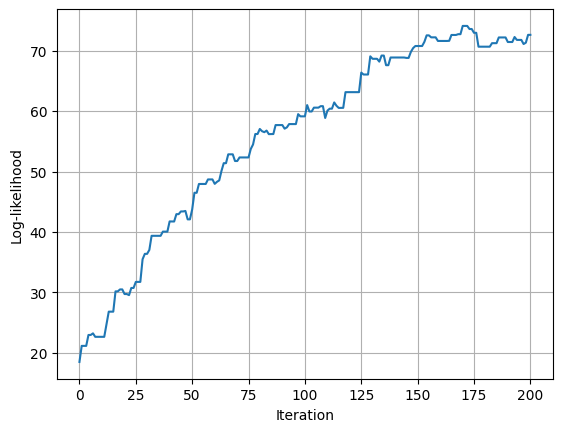

In [10]:
plt.plot(lls)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
# plt.savefig('./cell_mcmc_lls.png', dpi=150, bbox_inches='tight')

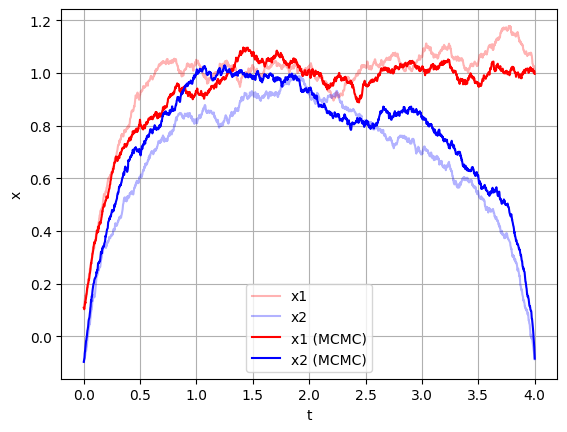

In [11]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r', alpha=0.3)
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b', alpha=0.3)
plt.plot(path_mcmc.ts, path_mcmc.xs[:, 0], label='x1 (MCMC)', color='r')
plt.plot(path_mcmc.ts, path_mcmc.xs[:, 1], label='x2 (MCMC)', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
# plt.savefig('./cell_mcmc_sample.png', dpi=150, bbox_inches='tight')